# KE5105 - Building Electrical Consumption Forecasting

# Extract, Transform and Load Data 2 - Data Exploration

## Summary of Findings

... to be filled in ...

## Load Libraries

In [1]:
%matplotlib inline

import pandas as pd
import myUtilities as myUtils

pd.options.display.max_columns = 20

## Load Data

In [2]:
# Load the time series data for 1 building (SDE-3).
sde3_list = myUtils.load_data_by_bldg('SDE-3')
for i in sde3_list[:3]:
    print(i[0], '\n')
    print(i[3].iloc[:5, :], '\n')

SDE-3_May2018.csv 

           Pt_timeStamp PWM-SDE3 IC1 PWM-SDE3 IC2  PWM-SDE3 MCC (AC)  \
0  1/5/2018 12:00:00 AM   847,789.88   525,517.88                0.0   
1  1/5/2018 12:30:00 AM   847,857.44   525,556.69                0.0   
2   1/5/2018 1:00:00 AM   847,920.50   525,595.31                0.0   
3   1/5/2018 1:30:00 AM   847,983.50   525,633.38                0.0   
4   1/5/2018 2:00:00 AM   848,047.50   525,671.50                0.0   

   PWM-CELC IC1 PWM-CELC IC2      PWM-SDE1  PWM-SDE2 SSB  PWM-SDE2 AC  \
0  1,594,258.00   708,561.63  1,170,756.63  3,394,773.50          0.0   
1  1,594,258.00   708,563.88  1,170,760.75  3,394,784.75          0.0   
2  1,594,258.13   708,566.31  1,170,764.75  3,394,795.50          0.0   
3  1,594,258.25   708,568.44  1,170,769.00  3,394,805.50          0.0   
4  1,594,258.38   708,570.63  1,170,773.25  3,394,816.00          0.0   

   PWM-SDE3 Ext PWM-Street Light  BTU-SDE3-Chiller Plant    BTU-SDE3-2  \
0  1,217,990.63         3,246.15  

Note that the date/time is encoded differently for May 2018 (d/m/y) vs Jul 2016 (m/d/y). 

## Explore the date/time field

In [3]:
# Try to convert date/time for May 2018 using default parameters. This does not work.
print(sde3_list[0][0])
print('raw =', sde3_list[0][3].loc[:, 'Pt_timeStamp'][0])
processed_datetime = pd.to_datetime(sde3_list[0][3].loc[:, 'Pt_timeStamp'])
print('processed =', processed_datetime[0])
print('day =', processed_datetime[0].day, 'month = ', processed_datetime[0].month, 'year = ', processed_datetime[0].year)

SDE-3_May2018.csv
raw = 1/5/2018 12:00:00 AM


processed = 2018-01-05 00:00:00
day = 5 month =  1 year =  2018


In [4]:
# Try to convert date/time for May 2018 using infer_datetime_format=True. This does not work.
print(sde3_list[0][0])
print('raw =', sde3_list[0][3].loc[:, 'Pt_timeStamp'][0])
processed_datetime = pd.to_datetime(sde3_list[0][3].loc[:, 'Pt_timeStamp'], infer_datetime_format=True)
print('processed =', processed_datetime[0])
print('day =', processed_datetime[0].day, 'month = ', processed_datetime[0].month, 'year = ', processed_datetime[0].year)

SDE-3_May2018.csv
raw = 1/5/2018 12:00:00 AM


processed = 2018-01-05 00:00:00
day = 5 month =  1 year =  2018


In [5]:
# Try to convert date/time for May 2018 using dayfirst=True. This works!
print(sde3_list[0][0])
print('raw =', sde3_list[0][3].loc[:, 'Pt_timeStamp'][0])
processed_datetime = pd.to_datetime(sde3_list[0][3].loc[:, 'Pt_timeStamp'], dayfirst=True)
print('processed =', processed_datetime[0])
print('day =', processed_datetime[0].day, 'month = ', processed_datetime[0].month, 'year = ', processed_datetime[0].year)

SDE-3_May2018.csv
raw = 1/5/2018 12:00:00 AM


processed = 2018-05-01 00:00:00
day = 1 month =  5 year =  2018


In [6]:
# Try to convert date/time for Jul 2016 using default parameters. This works.
print(sde3_list[1][0])
print('raw =', sde3_list[1][3].loc[:, 'Pt_timeStamp'][0])
processed_datetime = pd.to_datetime(sde3_list[1][3].loc[:, 'Pt_timeStamp'])
print('processed =', processed_datetime[0])
print('day =', processed_datetime[0].day, 'month = ', processed_datetime[0].month, 'year = ', processed_datetime[0].year)

SDE-3_Jul2016.csv
raw = 7/1/2016 12:00:00 AM


processed = 2016-07-01 00:00:00
day = 1 month =  7 year =  2016


It looks like we have to convert the encoded date/time using different conversion functions. Check through all the files to determine their date/time encoding used.

In [7]:
# Iterate through all the files to check their date/time encoding.
mylist = []
for i in sde3_list:
    if not i[3].empty:
        if i[2] != 1:
            # Check the 1st datetime value.
            mylist.append([i[1], i[2], int(i[3].iloc[0, 0].split('/')[1]) == i[2]])
        else:
            # For Jan, need to check datetime value for 2nd day i.e. 48 x 2 = 96.
            mylist.append([i[1], i[2], int(i[3].iloc[96, 0].split('/')[1]) == i[2]])
            
# Convert list to dataframe. 
datetime_encoding_df = pd.DataFrame(mylist, columns=['year', 'month', 'dayfirst'])

# Reindex the dataframe using the year/month, add missing values for any period with no files. 
datetime_encoding_df['date'] = pd.to_datetime(datetime_encoding_df['year'].astype(str) + '/' + datetime_encoding_df['month'].astype(str))
datetime_encoding_df['date'] = datetime_encoding_df['date'].dt.to_period('M')
datetime_encoding_df.set_index('date', inplace=True)
all_dates = pd.date_range('5/2015', '8/2018', freq='M').to_period('M')
datetime_encoding_df = datetime_encoding_df.reindex(all_dates)
datetime_encoding_df.sort_index(inplace=True)
#datetime_encoding_df = datetime_encoding_df.fillna(-1)

# Convert boolean to numeric for plotting.
datetime_encoding_df['dayfirst'] = datetime_encoding_df['dayfirst'].astype('float')
datetime_encoding_df.head()

,year,month,dayfirst
2015-05,NaN,NaN,NaN
2015-06,2015.0,6.0,0.0
2015-07,2015.0,7.0,0.0
2015-08,2015.0,8.0,0.0
2015-09,2015.0,9.0,0.0


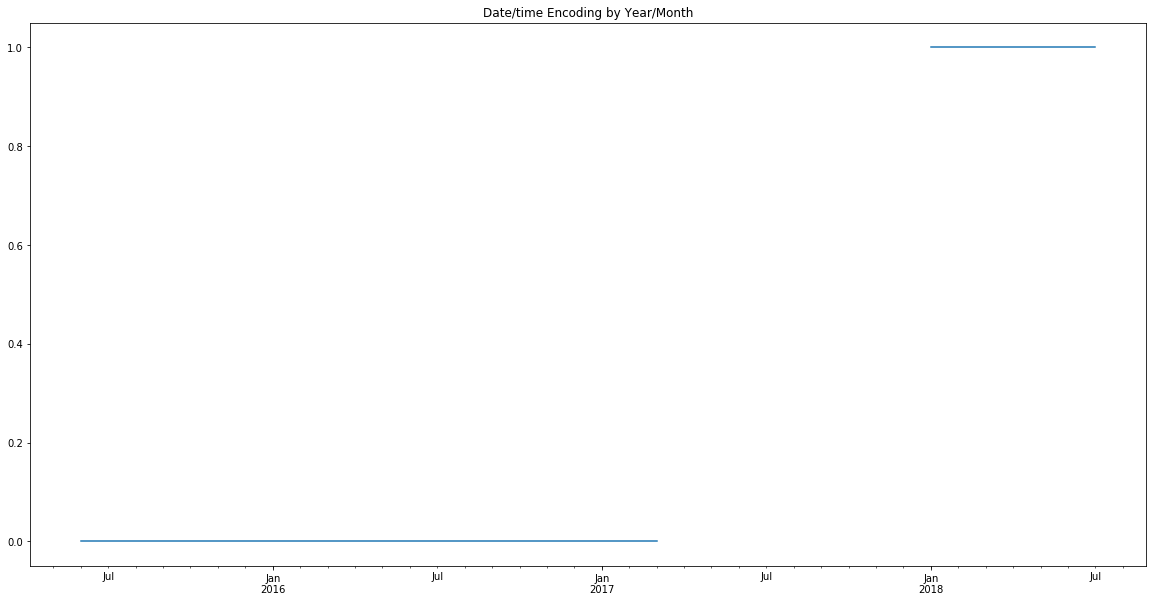

In [8]:
datetime_encoding_df.loc[:, 'dayfirst'].plot(figsize=(20, 10), title='Date/time Encoding by Year/Month')

In the above plot, the legend is :
* missing : no files
* 0       : month first i.e. m/d/y
* 1       : day first i.e. d/m/y

The files are encoded **month first** for the period before the data outage and **day first** after.

## Explore the other data fields

In [9]:
sde3_list[0][3].columns

Index(['Pt_timeStamp', 'PWM-SDE3 IC1', 'PWM-SDE3 IC2', 'PWM-SDE3 MCC (AC)',
       'PWM-CELC IC1', 'PWM-CELC IC2', 'PWM-SDE1', 'PWM-SDE2 SSB',
       'PWM-SDE2 AC', 'PWM-SDE3 Ext', 'PWM-Street Light',
       'BTU-SDE3-Chiller Plant', 'BTU-SDE3-2', 'BTU-SDE3 1&2'],
      dtype='object')

In [10]:
sde3_list[0][3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 14 columns):
Pt_timeStamp              1487 non-null object
PWM-SDE3 IC1              1450 non-null object
PWM-SDE3 IC2              1450 non-null object
PWM-SDE3 MCC (AC)         1450 non-null float64
PWM-CELC IC1              1487 non-null object
PWM-CELC IC2              1487 non-null object
PWM-SDE1                  1483 non-null object
PWM-SDE2 SSB              1486 non-null object
PWM-SDE2 AC               1486 non-null float64
PWM-SDE3 Ext              1483 non-null object
PWM-Street Light          1450 non-null object
BTU-SDE3-Chiller Plant    1450 non-null float64
BTU-SDE3-2                1450 non-null object
BTU-SDE3 1&2              1450 non-null object
dtypes: float64(3), object(11)
memory usage: 162.7+ KB


We need to convert the objects to a numeric type e.g. float for processing.

In [11]:
# There is a mixture of strings and floats.
sde3_list[0][3].loc[:, 'PWM-SDE3 IC1'].apply(lambda x: type(x)).unique()

array([<class 'str'>, <class 'float'>], dtype=object)

In [12]:
# There are commas in the string. These need to be removed before conversion to a numeric type.
sde3_list[0][3].loc[:, 'PWM-SDE3 IC1'].head()

0    847,789.88
1    847,857.44
2    847,920.50
3    847,983.50
4    848,047.50
Name: PWM-SDE3 IC1, dtype: object

In [13]:
# Convert all to string to remove the commas to allow conversion to float.
sde3_list[0][3]['PWM-SDE3 IC1'].astype('str').apply(lambda x: x.replace(',', '')).astype('float').head(20)

0     847789.88
1     847857.44
2     847920.50
3     847983.50
4     848047.50
5     848110.38
6     848173.88
7     848237.81
8     848300.94
9     848364.25
10    848427.50
11    848491.06
12    848554.75
13    848619.25
14    848681.81
15    848741.56
16    848801.81
17    848864.38
18    848927.31
19    848991.88
Name: PWM-SDE3 IC1, dtype: float64

## Convert the time series data for SDE-3.

In [14]:
# Convert the date/time for all the dataframes in the list.
for i in sde3_list:
    if not i[3].empty:
        if myUtils.is_day_first(i[0], i[3]):
            i[3].loc[:, 'Pt_timeStamp'] = pd.to_datetime(i[3].loc[:, 'Pt_timeStamp'], dayfirst=True)
        else:
            i[3].loc[:, 'Pt_timeStamp'] = pd.to_datetime(i[3].loc[:, 'Pt_timeStamp'])

In [15]:
# Convert the strings to floats for all the dataframes in the list.
for i in sde3_list:
    if not i[3].empty:
        for j in i[3].iloc[:, 1:].columns:
            i[3][j] = i[3][j].astype('str').apply(lambda x: x.replace(',', '')).astype('float')

In [16]:
# Concatenate the list of dataframes into 1 single dataframe.
df_list = []
for i in sde3_list:
    df_list.append(i[3])
sde3_df = pd.concat(df_list)

In [17]:
# Reindex the dataframe using the year/month/day/time, add missing values for any period with no files. 
sde3_df.set_index('Pt_timeStamp', inplace=True)
all_dates = pd.date_range('5/2015', '8/2018', freq='30min')
sde3_df = sde3_df.reindex(all_dates)
sde3_df.sort_index(inplace=True)

In [18]:
# These are the missing values out of the 40460 observations in the time series data. There could also be missing observations i.e. no indexed row. We will look into this later.
sde3_df.isnull().sum()

PWM-SDE3 IC1              17247
PWM-SDE3 IC2              17247
PWM-SDE3 MCC (AC)         17247
PWM-CELC IC1              17508
PWM-CELC IC2              17508
PWM-SDE1                  16631
PWM-SDE2 SSB              16613
PWM-SDE2 AC               16613
PWM-SDE3 Ext              16631
PWM-Street Light          17247
BTU-SDE3-Chiller Plant    17440
BTU-SDE3-2                17440
BTU-SDE3 1&2              17439
dtype: int64

In [19]:
# These are the zero values in the data.
sde3_df.apply(lambda x: x.eq(0)).sum()

PWM-SDE3 IC1                702
PWM-SDE3 IC2                702
PWM-SDE3 MCC (AC)          9524
PWM-CELC IC1                  4
PWM-CELC IC2                  4
PWM-SDE1                   3751
PWM-SDE2 SSB                  0
PWM-SDE2 AC               10161
PWM-SDE3 Ext                  0
PWM-Street Light            702
BTU-SDE3-Chiller Plant     9524
BTU-SDE3-2                    0
BTU-SDE3 1&2                  0
dtype: int64

In [20]:
PWM_columns = []
for i in sde3_df.columns:
    if 'PWM' in i:
        PWM_columns.append(i)
PWM_columns

['PWM-SDE3 IC1',
 'PWM-SDE3 IC2',
 'PWM-SDE3 MCC (AC)',
 'PWM-CELC IC1',
 'PWM-CELC IC2',
 'PWM-SDE1',
 'PWM-SDE2 SSB',
 'PWM-SDE2 AC',
 'PWM-SDE3 Ext',
 'PWM-Street Light']

## Plots of PWM from Jun 2015 to 2018 Jul

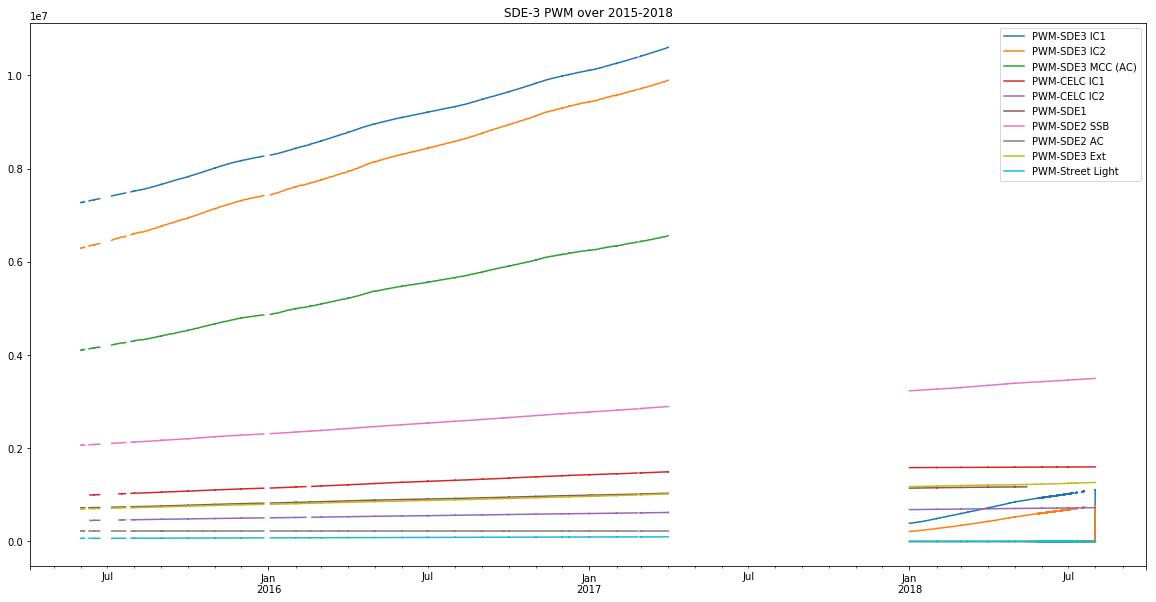

In [21]:
sde3_df.loc[:, PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 2015-2018')

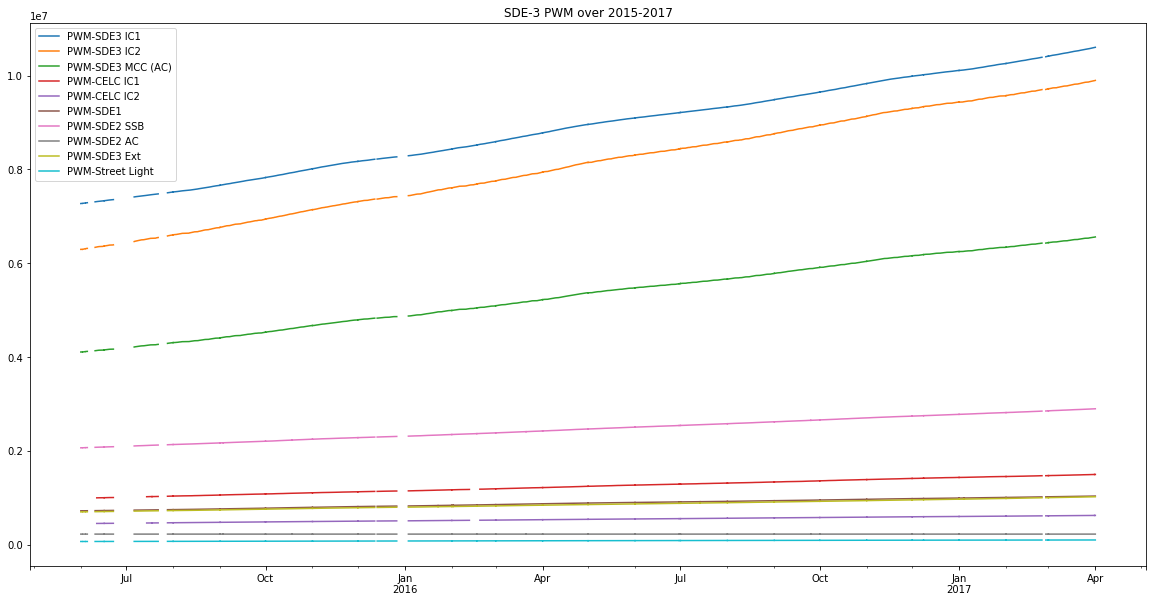

In [22]:
sde3_df.loc['2015-05-01 00H':'2017-05-01 00H', PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 2015-2017')

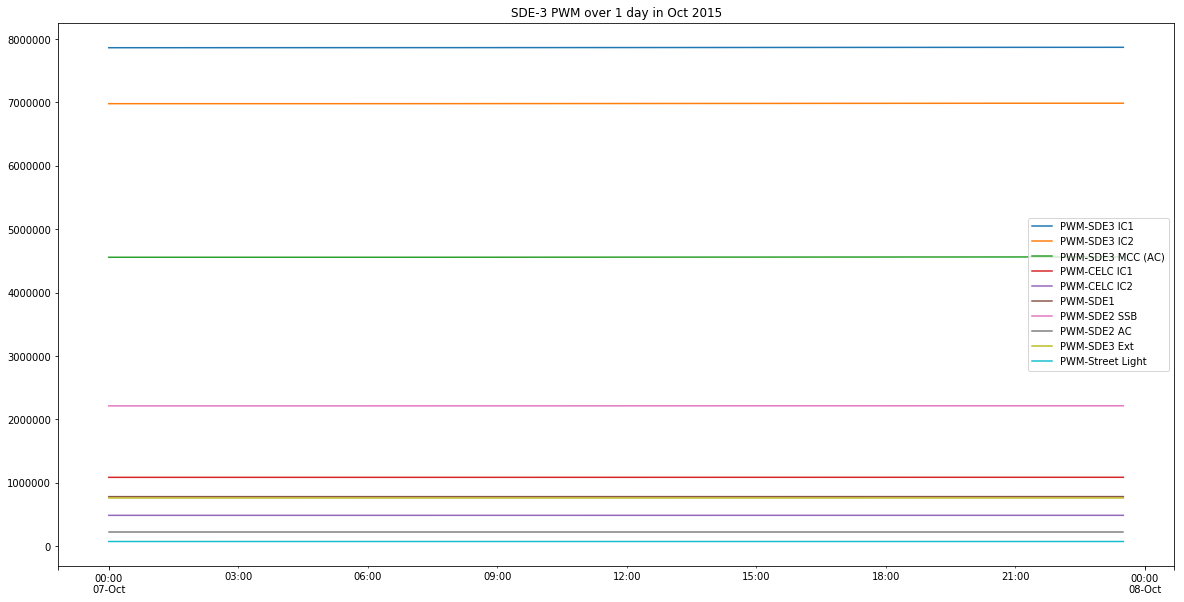

In [23]:
sde3_df.loc['2015-10-07 00H':'2015-10-07 23H', PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 1 day in Oct 2015')

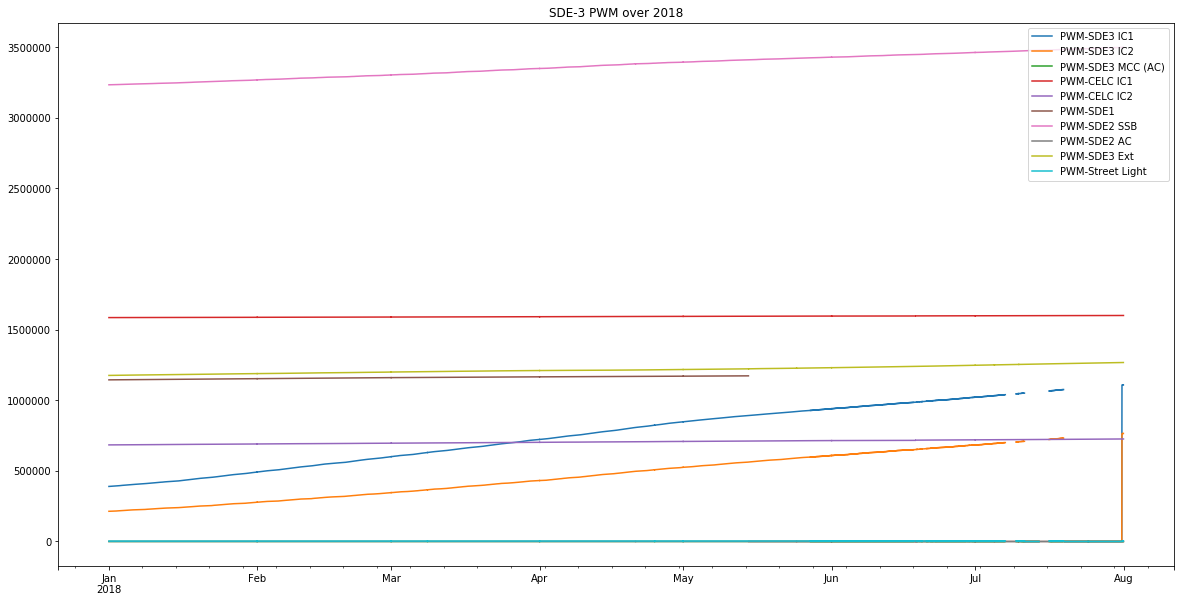

In [24]:
sde3_df.loc['2018-01-01 00H':'2018-08-01 23H', PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 2018')

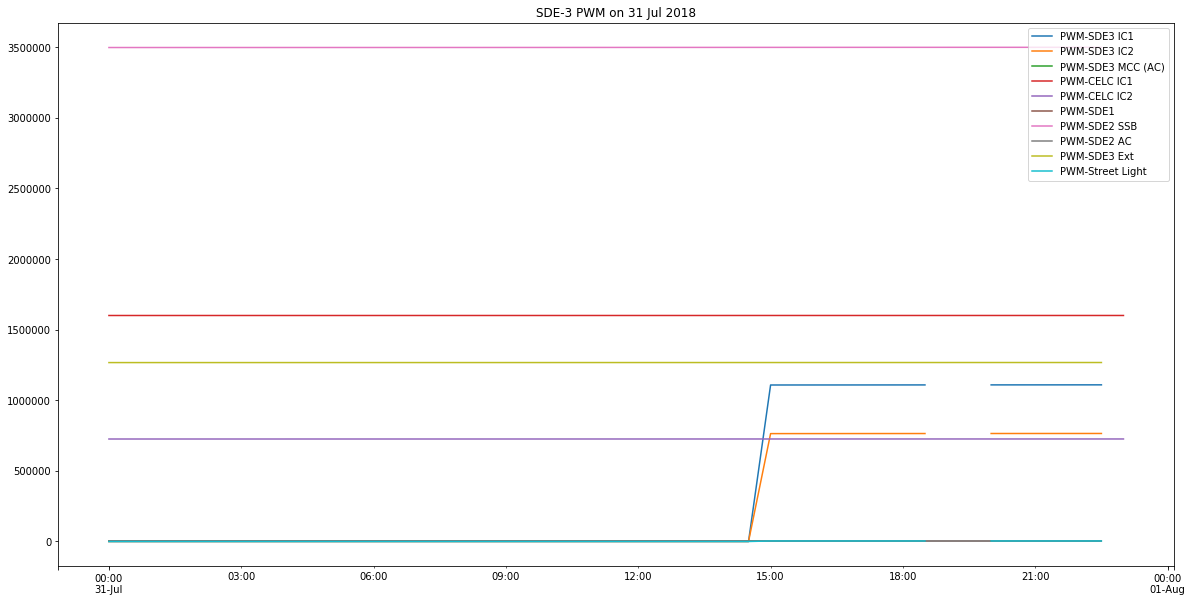

In [25]:
sde3_df.loc['2018-07-31 00H':'2018-08-01 23H', PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM on 31 Jul 2018')

## Explore the time series data of other buildings

In [2]:
## Combine the csv files for the building into 1 file.
myUtils.combine_csv_files_by_bldg('SDE-2')

In [4]:
#import datetime
#sde2_df = pd.read_csv('source/combined_bldg_data/SDE-2.csv', index_col=0, dtype={0:datetime.datetime})
sde2_df = pd.read_csv('source/combined_bldg_data/SDE-2.csv', index_col=0, parse_dates=True)

In [9]:
sde2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57025 entries, 2015-05-01 00:00:00 to 2018-08-01 00:00:00
Data columns (total 6 columns):
BTU SDE 2        882 non-null float64
BTU-SDE2         40412 non-null float64
PWM SDE 2 AC     882 non-null float64
PWM SDE 2 MSB    882 non-null float64
PWM SDE 2 SSB    882 non-null float64
PWM-SDE2 SSB     40412 non-null float64
dtypes: float64(6)
memory usage: 3.0 MB


In [11]:
sde2_df.iloc[:5, :]

,BTU SDE 2,BTU-SDE2,PWM SDE 2 AC,PWM SDE 2 MSB,PWM SDE 2 SSB,PWM-SDE2 SSB
Pt_timeStamp,,,,,,
2015-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN


BTU SDE 2, BTU-SDE2 and PWM SDE 2 SSB, PWM-SDE2 SSB look like the same columns. We need to remove **whitespaces** and **dashes** to correctly merge the columns.

In [5]:
PWM_columns = []
for i in sde2_df.columns:
    if 'PWM' in i:
        PWM_columns.append(i)
PWM_columns

['PWM SDE 2 AC', 'PWM SDE 2 MSB', 'PWM SDE 2 SSB', 'PWM-SDE2 SSB']

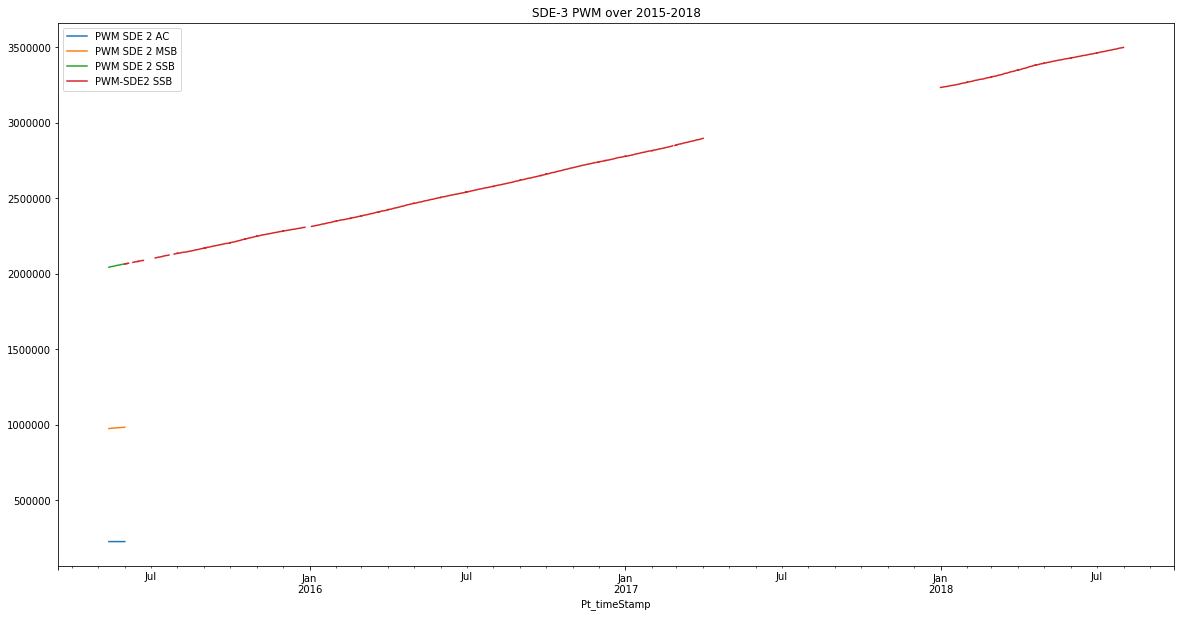

In [6]:
sde2_df.loc[:, PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 2015-2018')